#### 1: DATA PREPARATION & EXPLORATION

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
df = pd.read_csv("C:/Users/harik/Data science Assignment/exchange_rate.csv")

In [9]:
df.columns = ["Date", "USD_AUD"]

In [10]:
df["Date"] = pd.to_datetime(
    df["Date"],
    format="mixed",
    dayfirst=True
)

In [11]:
df.head()

,Date,USD_AUD
0,1990-01-01,0.7855
1,1990-01-02,0.7818
2,1990-01-03,0.7867
3,1990-01-04,0.7860
4,1990-01-05,0.7849


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     7588 non-null   datetime64[ns]
 1   USD_AUD  7588 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 118.7 KB


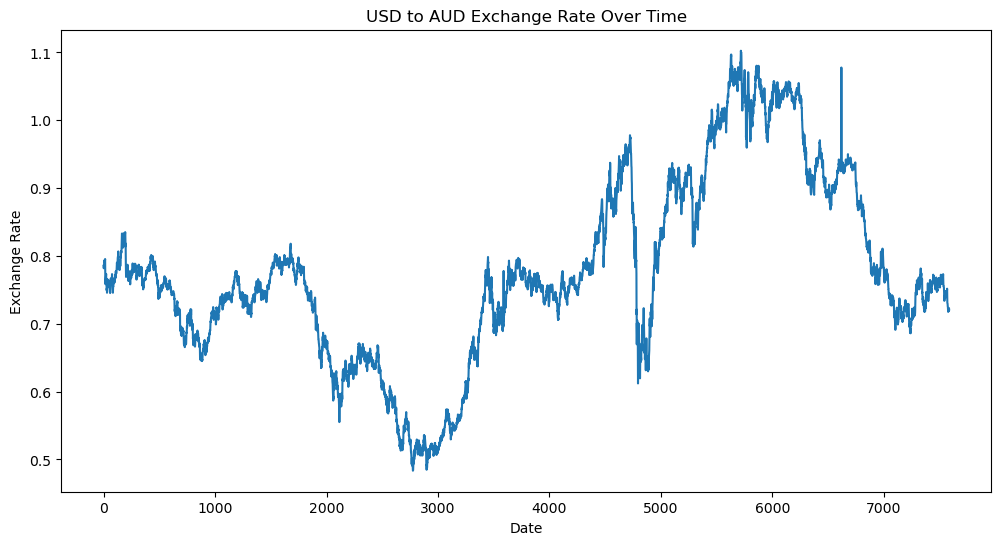

In [13]:
plt.figure(figsize=(12,6))
plt.plot(df["USD_AUD"])
plt.title("USD to AUD Exchange Rate Over Time")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.show()

In [14]:
# Check missing values
print(df.isna().sum())

# Forward fill missing values
df["USD_AUD"] = df["USD_AUD"].fillna(method="ffill")

Date       0
USD_AUD    0
dtype: int64


C:\Users\harik\AppData\Local\Temp\ipykernel_11168\1030778514.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["USD_AUD"] = df["USD_AUD"].fillna(method="ffill")


#### 2: ARIMA MODEL

In [15]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df["USD_AUD"])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

ADF Statistic: -1.6649941807381343
p-value: 0.44923273535979974


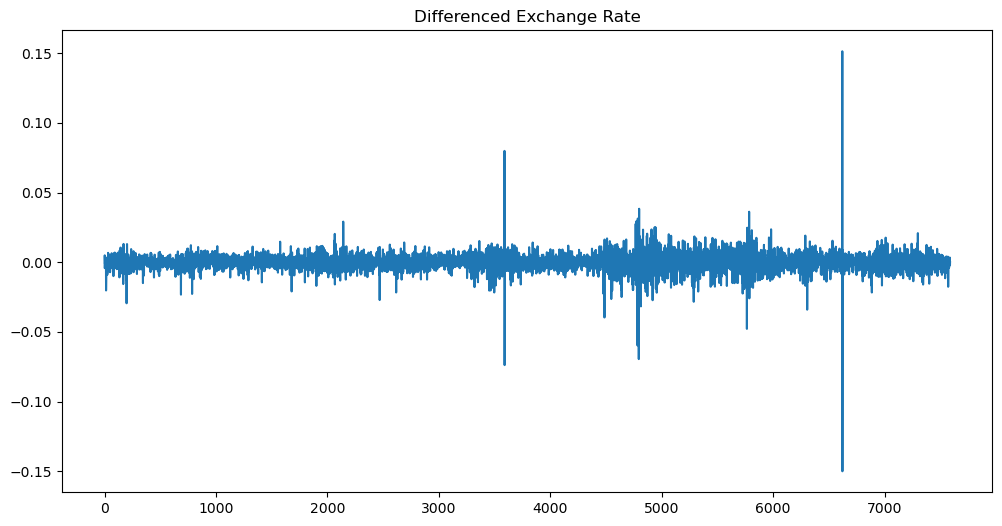

In [16]:
df["USD_AUD_diff"] = df["USD_AUD"].diff().dropna()

plt.figure(figsize=(12,6))
plt.plot(df["USD_AUD_diff"])
plt.title("Differenced Exchange Rate")
plt.show()

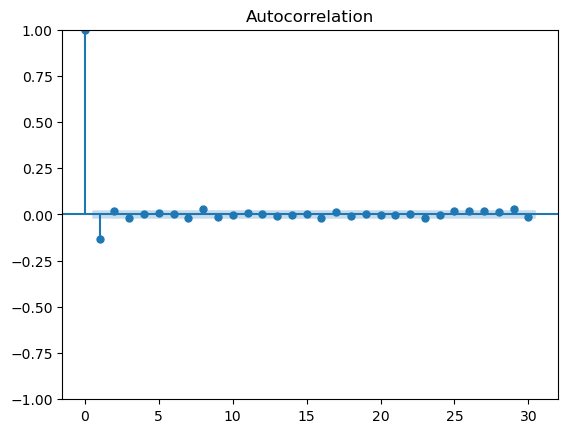

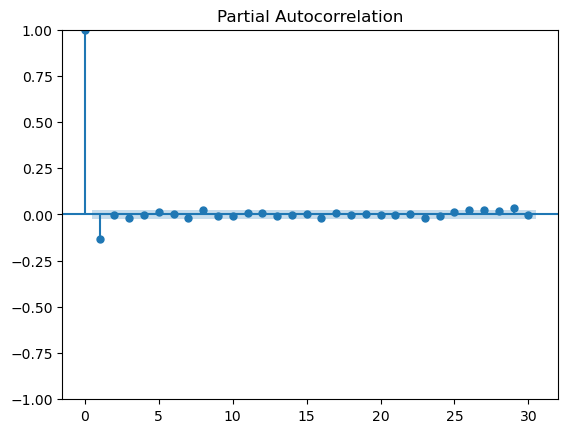

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df["USD_AUD_diff"].dropna(), lags=30)
plt.show()

plot_pacf(df["USD_AUD_diff"].dropna(), lags=30)
plt.show()

In [18]:
train_size = int(len(df) * 0.8)
train = df["USD_AUD"][:train_size]
test = df["USD_AUD"][train_size:]

In [19]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train, order=(1,1,1))
arima_fit = arima_model.fit()

print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                USD_AUD   No. Observations:                 6070
Model:                 ARIMA(1, 1, 1)   Log Likelihood               22719.046
Date:                Sat, 13 Dec 2025   AIC                         -45432.092
Time:                        21:54:41   BIC                         -45411.959
Sample:                             0   HQIC                        -45425.104
                               - 6070                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5972      0.062     -9.648      0.000      -0.719      -0.476
ma.L1          0.5398      0.064      8.430      0.000       0.414       0.665
sigma2      3.281e-05   1.95e-07    168.198      0.0

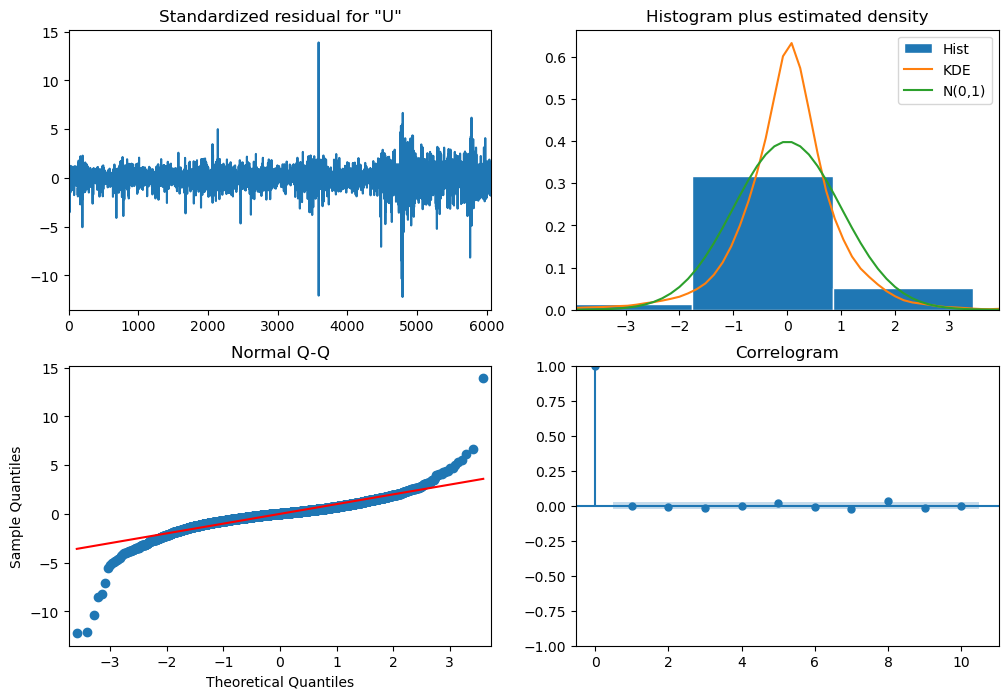

In [20]:
arima_fit.plot_diagnostics(figsize=(12,8))
plt.show()

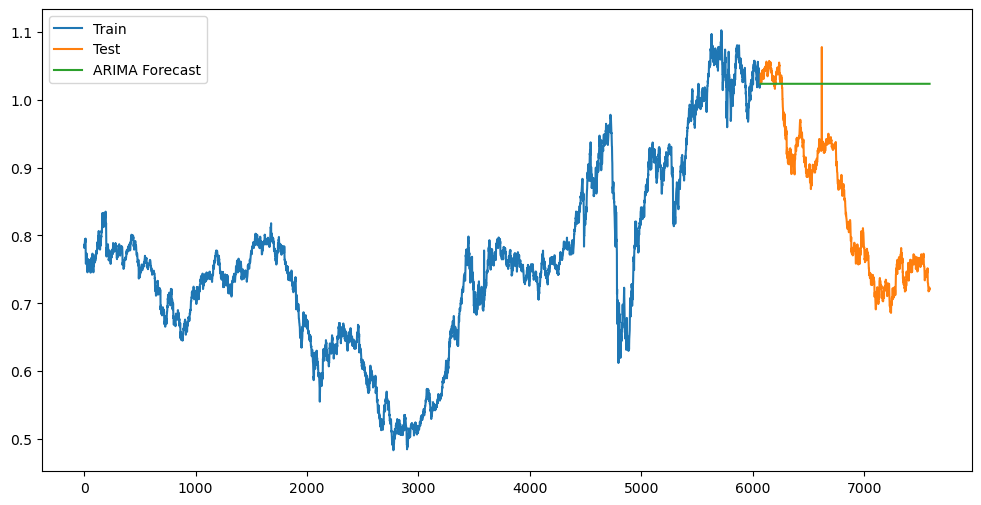

In [21]:
arima_forecast = arima_fit.forecast(steps=len(test))

plt.figure(figsize=(12,6))
plt.plot(train, label="Train")
plt.plot(test, label="Test")
plt.plot(test.index, arima_forecast, label="ARIMA Forecast")
plt.legend()
plt.show()

#### 3: EXPONENTIAL SMOOTHING

In [22]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

ets_model = ExponentialSmoothing(
    train,
    trend="add",
    seasonal=None
)

ets_fit = ets_model.fit()
ets_forecast = ets_fit.forecast(len(test))

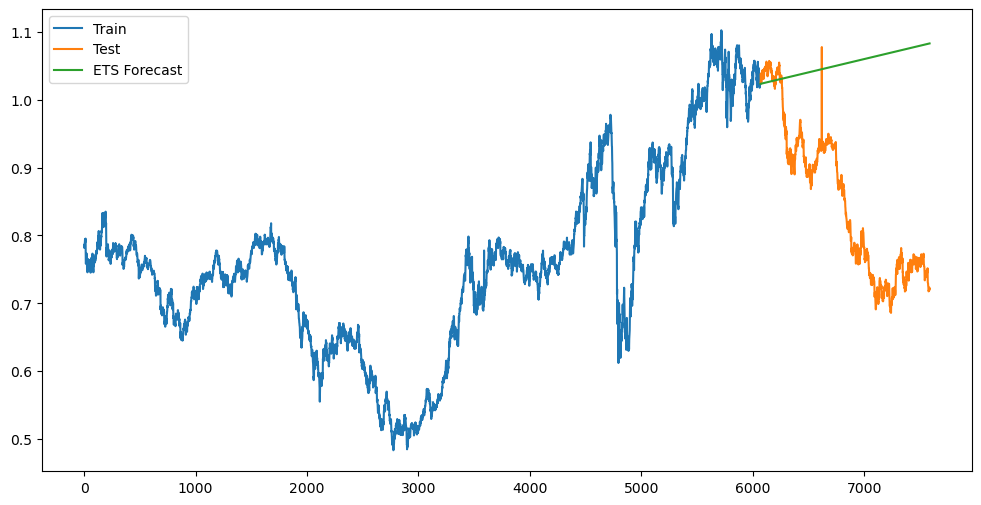

In [23]:
plt.figure(figsize=(12,6))
plt.plot(train, label="Train")
plt.plot(test, label="Test")
plt.plot(test.index, ets_forecast, label="ETS Forecast")
plt.legend()
plt.show()

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mae, rmse, mape

arima_mae, arima_rmse, arima_mape = evaluate(test, arima_forecast)
ets_mae, ets_rmse, ets_mape = evaluate(test, ets_forecast)

results = pd.DataFrame({
    "Model": ["ARIMA", "Exponential Smoothing"],
    "MAE": [arima_mae, ets_mae],
    "RMSE": [arima_rmse, ets_rmse],
    "MAPE (%)": [arima_mape, ets_mape]
})

print(results)

                   Model       MAE      RMSE   MAPE (%)
0                  ARIMA  0.177710  0.205437  22.797966
1  Exponential Smoothing  0.206596  0.239104  26.508664


#### 5: MODEL COMPARISON & CONCLUSION

Model Comparison (Write in Report)
ARIMA

Advantages:

Captures autocorrelation

Strong statistical foundation

Limitations:

Requires stationarity

Parameter tuning is complex